In [1]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv
import copy
import warnings
warnings.filterwarnings('ignore')

# name and files for the simulation studied

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/'

path2 = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1.xtc'

In [2]:
# name and files for the simulation studied

name = '_DPPC_DIPC_chol'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/'

path2 = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

In [3]:
# load gro and xtc files
u = mda.Universe( path+fgro, path+fxtc)

In [4]:
sel_all = u.select_atoms("all and resname DPPC")

In [5]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel_all)
v.add_spacefill(sel_all, scale=2.0)
v

A Jupyter Widget

# Diffusion

In [6]:
# boucle pour suivre un lipide pendant la trajectoire pour calculer le MSD et le coeff de diffusion
tmes = 10
traj = []
for ts in u.trajectory:
     if (ts.frame%tmes == 0):
            #print(ts.frame)
            str_sel= "name GL1 and resname DIPC"
            p = u.select_atoms(str_sel).positions
            traj.append(p)

(1000, 3190, 3)


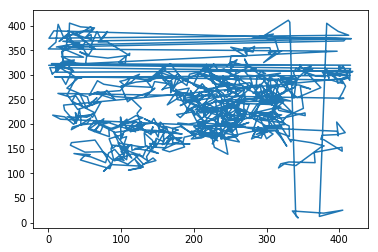

In [7]:
t = np.array(traj)
nbr=22 # indice du lipide que l'on suit
print(np.shape(t)) # nb de frames - indice du lipide - coordonnées
x=t[:,nbr,0]
y=t[:,nbr,1]
plt.plot(x,y)